In [1]:
import vcf
import vcf.utils
import pysam
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# VCF / BAM comparison tool

Compares the INDEL calls and alignments between two datasets. Designed to answer the question "why is Swiftlong (B) so much worse?" 

Input files:

Dataset A & B:
* VCF from hap.py
* BAM file


In [17]:
a_happy_vcf = vcf.Reader(filename="a50_variant_analysis/Nextera-10ng-1_happy/Nextera-10ng-1.vcf.gz")
a_vcf = vcf.Reader(filename="a40_vcf/Nextera-10ng-1.scored.vcf")

a_bam = pysam.AlignmentFile("/ypool/bulk/nsc/kitComparison/10_bwa/Nextera-10ng-1_HYK7TCCXY_L004.sorted.bam")

In [18]:
b_happy_vcf = vcf.Reader(filename="a50_variant_analysis/Swiftlong-10ng-3_happy/Swiftlong-10ng-3.vcf.gz")
b_vcf = vcf.Reader(filename="a40_vcf/Swiftlong-10ng-3.scored.vcf")

b_bam = pysam.AlignmentFile("/ypool/bulk/nsc/kitComparison/10_bwa/Nextera-100ng-3_HYK7TCCXY_L002.sorted.bam")

In [19]:
current_chromosome = None

In [96]:
# Log depths
items = []

for _, (a_rec, a_rec2, b_rec, b_rec2) in zip(range(300000), vcf.utils.walk_together(a_happy_vcf, a_vcf, b_happy_vcf, b_vcf)):
    #any_rec = recs[0] or recs[1]
    a_or_b_rec = a_rec or b_rec
    if not a_or_b_rec: continue
    if a_or_b_rec.CHROM != current_chromosome:
        current_chromosome = a_or_b_rec.CHROM
        print("Chromosome:", current_chromosome)
    if a_or_b_rec.is_indel:
        #print(a_or_b_rec.CHROM, a_or_b_rec.POS)
        item = {
            'chrom': a_or_b_rec.CHROM,
            'pos': a_or_b_rec.POS,
            'a_is_tp': a_rec is not None and a_rec.samples[1].data.BD == 'TP',
            'a_dp': a_bam.count(a_or_b_rec.CHROM, a_or_b_rec.start, a_or_b_rec.start+1),
            'b_is_tp': b_rec is not None and b_rec.samples[1].data.BD == 'TP',
            'b_dp': b_bam.count(a_or_b_rec.CHROM, a_or_b_rec.start, a_or_b_rec.start+1),
            'a_qq': a_rec is not None and a_rec.QUAL,
            'b_qq': b_rec is not None and b_rec.QUAL
        }
        item['is_tp'] = item['b_is_tp'] or item['a_is_tp']
        item['type'] = a_or_b_rec.samples[0].data.BI
        #if item['type'] in ('d1_5' 'i1_5'):
        item['size'] = len(a_or_b_rec.ALT[0]) - len(a_or_b_rec.REF)
        #if item['size'] == 0:
        #    print(a_or_b_rec.REF)
        #    print(a_or_b_rec.ALT)
        #    break
        items.append(item)
    
if not a_or_b_rec:
    print("Got to the end")
else:
    print("Got to position", a_or_b_rec.CHROM, a_or_b_rec.POS)

Chromosome: chr12
Chromosome: chr13
Got to position chr13 32951062


In [97]:
df = pd.DataFrame(items)
print("Items:", len(items))
df.head(n=2)

Items: 59992


,chrom,pos,a_is_tp,a_dp,b_is_tp,b_dp,a_qq,b_qq,is_tp,type,size
0,chr11,120334863,False,8,False,1,94.06,False,False,None,-4
1,chr11,120341307,True,8,False,5,277.6,0,True,i16_plus,38


Text(0.5, 1.0, 'B depth on all called variants (all VCF records), by whether TP or anything else FN/FP')

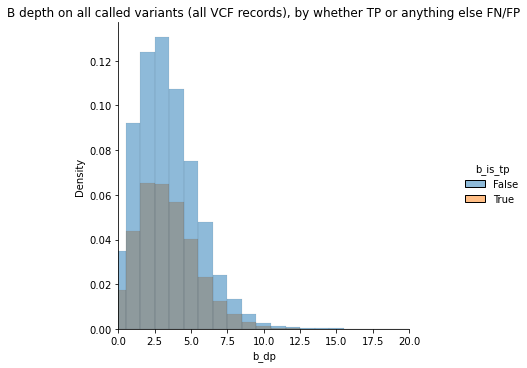

In [98]:
sns.displot(data=df, x='b_dp', hue='b_is_tp', discrete=True, common_norm=True, stat='density')
plt.xlim(0,20)
plt.title("B depth on all called variants (all VCF records), by whether TP or anything else FN/FP")

In [99]:
a_tp_data = df[df.a_is_tp]

Text(0.5, 1.0, 'B depth on all TP variants called by A')

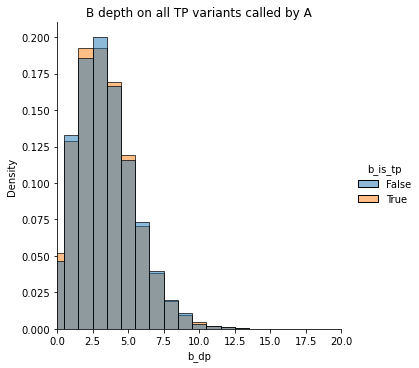

In [100]:
sns.displot(data=a_tp_data, x='b_dp', hue='b_is_tp', discrete=True, common_norm=False, stat='density')
plt.xlim(0,20)
plt.title("B depth on all TP variants called by A")

Text(0.5, 1.0, 'B depth on all TP variants called by A')

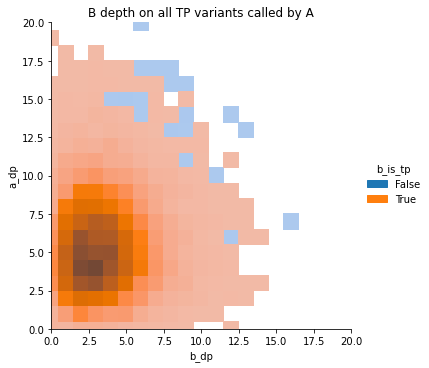

In [101]:
sns.displot(data=a_tp_data, x='b_dp', y='a_dp', hue='b_is_tp', discrete=True, common_norm=False, stat='density')
plt.xlim(0,20)
plt.ylim(0,20)
plt.title("B depth on all TP variants called by A")

Text(0.5, 1.0, 'B recall on A TPs by chromosome')

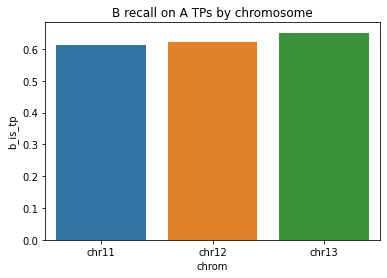

In [102]:
sns.barplot(data=a_tp_data.groupby('chrom', as_index=False).mean(), x='chrom', y='b_is_tp')
plt.title('B recall on A TPs by chromosome')

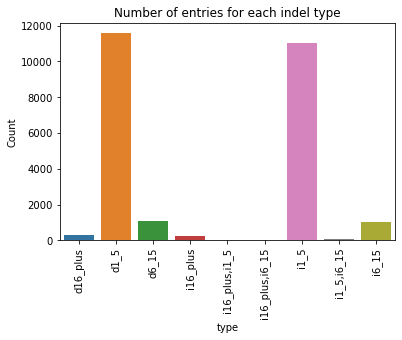

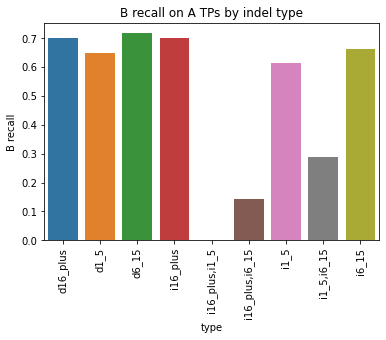

In [103]:
plt.figure()
sns.barplot(data=a_tp_data.groupby('type', as_index=False).count(), x='type', y='a_is_tp')
plt.title('Number of entries for each indel type')
plt.ylabel('Count')
plt.xticks(rotation=90)

plt.figure()
sns.barplot(data=a_tp_data.groupby('type', as_index=False).mean(), x='type', y='b_is_tp')
plt.title('B recall on A TPs by indel type')
plt.ylabel('B recall')
plt.xticks(rotation=90)
plt.show()

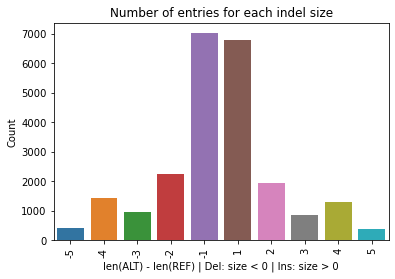

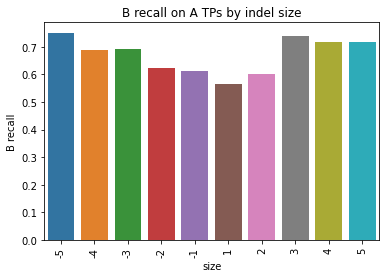

In [106]:
size_range_df=a_tp_data.loc[(a_tp_data['size']>-6)&(a_tp_data['size']<6)]
plt.figure()
sns.barplot(data=size_range_df.groupby('size', as_index=False).count(), x='size', y='a_is_tp')
plt.title('Number of entries for each indel size')
plt.ylabel('Count')
plt.xlabel('len(ALT) - len(REF) | Del: size < 0 | Ins: size > 0')
plt.xticks(rotation=90)

plt.figure()
sns.barplot(data=size_range_df.groupby('size', as_index=False).mean(), x='size', y='b_is_tp')
plt.title('B recall on A TPs by indel size')
plt.ylabel('B recall')
plt.xticks(rotation=90)
plt.show()